In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import  MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
#Preparing data

df = pd.read_csv('sp500_Adj close values.csv')

df.set_index('Date', inplace=True)



In [13]:
ticker = input('> What is the ticker for the company'
               ' whose adjusted close value you want to predict for? \n>').upper()

df = df.loc[:,[f'{ticker}']]

> What is the ticker for the company whose adjusted close value you want to predict for? 
>aapl


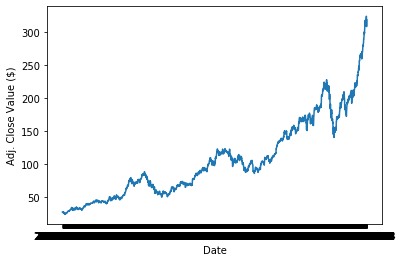

In [14]:
#visualize current graph

plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Adj. Close Value ($)')
plt.show()

In [15]:
test_size = int(input('How many days into the future do you want to predict for your test data? '
                      '\n(Ideally less than 2 years)\n'))

How many days into the future do you want to predict for your test data? 
(Ideally less than 2 years)
360


In [16]:
test_ind = len(df) - test_size

train = df.iloc[:test_ind]

test = df.iloc[test_ind:]

print(test)

                  AAPL
Date                  
2018-08-29  218.915482
2018-08-30  220.928101
2018-08-31  223.480713
2018-09-04  224.197418
2018-09-05  222.734589
...                ...
2020-01-29  324.339996
2020-01-30  323.869995
2020-01-31  309.510010
2020-02-03  308.660004
2020-02-04  318.850006

[360 rows x 1 columns]


In [17]:
scaler = MinMaxScaler()

scaler.fit(train)

scaled_train = scaler.transform(train)

scaled_test = scaler.transform(test)

In [18]:
length = int(test_size/2)

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

X, y = generator[0]

In [19]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1.42298873e-02 1.44696291e-02 1.22599899e-02 1.20072722e-02
 1.29144647e-02 1.17027402e-02 1.01540290e-02 1.20526433e-02
 1.12621050e-02 8.99411885e-03 1.48973182e-02 1.27524692e-02
 1.03808048e-02 3.69353032e-03 7.14085578e-03 9.00060186e-03
 1.02577173e-02 4.69145498e-03 6.46311378e-06 1.73658896e-03
 2.46882992e-03 4.65257686e-03 0.00000000e+00 2.20963917e-03
 1.34132480e-03 2.68267944e-03 1.98932654e-03 4.28969788e-03
 5.39779377e-03 7.35468541e-03 6.80389886e-03 7.05014349e-03
 6.23368319e-03 5.42369594e-03 3.24643200e-03 5.57918851e-03
 6.44751282e-03 8.14525349e-03 1.09769922e-02 1.08862700e-02
 1.11972750e-02 1.20915313e-02 1.74309682e-02 1.75152173e-02
 2.00683262e-02 2.12476755e-02 2.16753149e-02 2.23881565e-02
 2.05996638e-02 2.09949379e-02 2.07811381e-02 2.11245382e-02
 1.95693440e-02 2.11893285e-02 2.35285978e-02 2.41830627e-02
 2.24205218e-02 2.51744944e-02 2.61399841e-02 2.83820582e-02
 2.78312617e-02 2.84598244e-02 3.00927350e-02 3.07731319e-02
 3.146

In [20]:
n_features = 1

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/2
1999/1999 [==============================] - 829s 415ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2/2
1999/1999 [==============================] - 1096s 548ms/step - loss: 3.0575e-04 - val_loss: 5.4198e-04


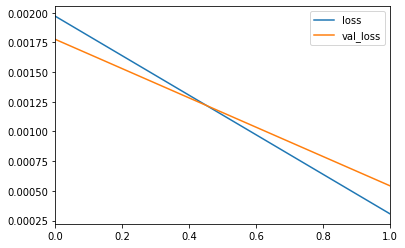

In [22]:
losses = pd.DataFrame(model.history.history)

losses.plot()

plt.show()

C:\Users\khatt\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


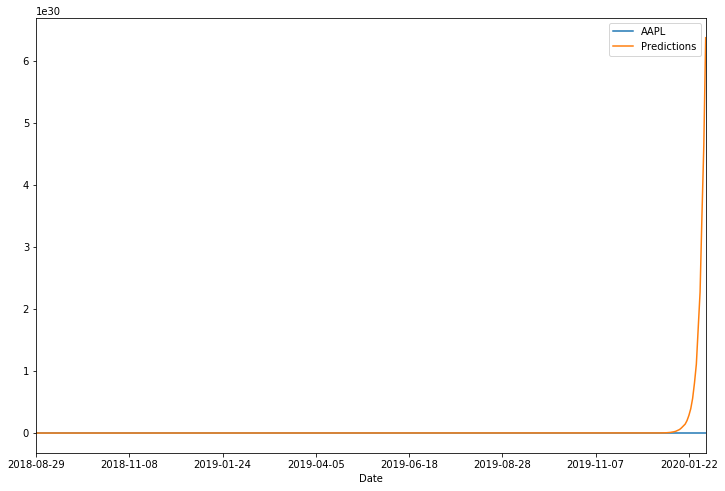

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)

test['Predictions'] = true_predictions

test.plot(figsize=(12,8))

plt.show()

In [24]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=10)

Epoch 1/2
1155/2359 [=============>................] - ETA: 14:32 - loss: 0.0027

In [ ]:
forecast = []

periods = int(input('> '))

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]

    forecast.append(current_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2020-02-05',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

In [ ]:
df.plot()
forecast_df.plot()

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2020-01-01','2021-04-01')